In [1]:
# Import packages.
from petsc4py import PETSc
from slepc4py import SLEPc

import numpy as np
import scipy

from matplotlib import pyplot as plt
import csv
import sys

# Check anaconda environment. Script needs complex petsc/slepc. Scalar type should be complex128.
from petsc4py import PETSc
print("Scalar type: " + str(PETSc.ScalarType))

Scalar type: <class 'numpy.complex128'>


In [2]:
Re = 200
base_dir = './backward_facing_step_compressible/'
case_path = base_dir + str(Re) + '/'

In [3]:
# # Load matrices.
# L = scipy.sparse.load_npz(case_path + 'L.npz')
# A = scipy.sparse.load_npz(case_path + 'A.npz')

# # Important: Here equations are formulatet as (\sigma A + L)q = 0.
# # However, slepc expects Lq = \sigma A q.
# # => Multiply A matrix with -1, before stability analysis.
# A = A * (-1)

In [4]:
n = 100
np.random.seed(1)

# Generate a random matrix R.
R = scipy.sparse.random(n, n, density=0.1, format="csr", random_state=1, data_rvs=np.random.rand)

# Create a symmetric positive definite matrix A.
A = R.transpose().dot(R) + n * scipy.sparse.eye(n, format="csr")  # Adding n*I ensures A is well-conditioned and invertible.

# # Create a mass matrix A as a diagonal matrix with random positive entries.
# A_diag = np.random.uniform(1.0, 2.0, n)
# A = scipy.sparse.diags(A_diag, format="csr")

# Create a stiffness matrix L using a finite-difference 1D Laplacian form:
#   - off-diagonals = -1, diagonal = 2.
diagonals = [-np.ones(n-1), 2*np.ones(n), -np.ones(n-1)]
offsets   = [-1, 0, 1]
L = scipy.sparse.diags(diagonals, offsets, shape=(n, n), format="csr")

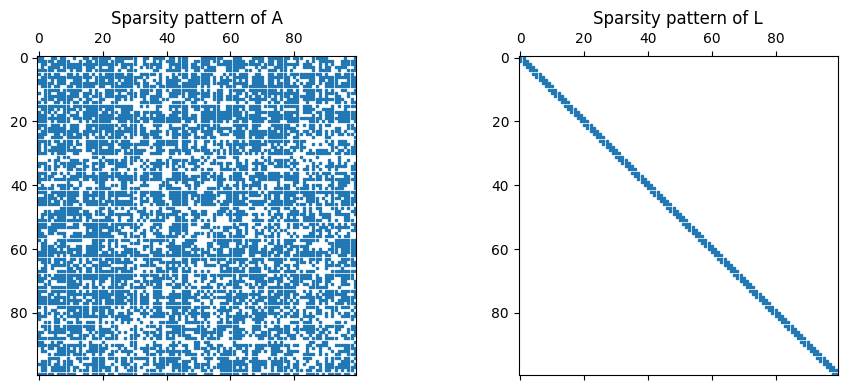

In [5]:
# Visualize the sparsity structure using spy plots.
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Sparsity pattern of A")
plt.spy(A, markersize=2)

plt.subplot(1, 2, 2)
plt.title("Sparsity pattern of L")
plt.spy(L, markersize=2)
plt.tight_layout()
plt.show()

In [6]:
# Convert from scipy to petsc matrices.
L_pet = PETSc.Mat().createAIJ(size=L.shape, csr=(L.indptr, L.indices, L.data))
A_pet = PETSc.Mat().createAIJ(size=A.shape, csr=(A.indptr, A.indices, A.data))

In [7]:
A_H_pet = A_pet.copy()
A_H_pet.hermitianTranspose()

L_H_pet = L_pet.copy()
L_H_pet.hermitianTranspose()

In [8]:
# n_ev = 50

# # Setup eigenvalue problem.
# LEP = SLEPc.EPS().create()
# LEP.setOperators(L_pet*L_H_pet, A_pet*A_H_pet)
# LEP.setProblemType(SLEPc.EPS.ProblemType.GNHEP)
# LEP.setType(SLEPc.EPS.Type.KRYLOVSCHUR)
# LEP.setDimensions(n_ev, PETSc.DECIDE, PETSc.DECIDE)
# # LEP.setTwoSided(True)
# LEP.setWhichEigenpairs(SLEPc.EPS.Which.LARGEST_REAL)
# # LEP.setWhichEigenpairs(SLEPc.EPS.Which.TARGET_MAGNITUDE)
# LEP.setTolerances(1e-9, 200)

# st = LEP.getST()
# ksp = st.getKSP()

# ksp.setType("preonly")
# pc = ksp.getPC()
# pc.setType("jacobi")

# LEP.setFromOptions()
# LEP.view()

# # Solve eigenvalue problem.
# LEP.solve()

# # Access solution.
# tol, maxit = LEP.getTolerances()
# nconv      = LEP.getConverged()
    
# print("Stopping condition: tol=%.4g, maxit=%d" % (tol, maxit))
# print("Number of converged eigenpairs %d" % nconv)

In [9]:
n_ev = 50

# Direct solver using LAPACK (for small dense problems).
LEP = SLEPc.EPS().create()
# Use original PETSc matrices. Adjust if you need L_pet*L_H_pet.
LEP.setOperators(L_pet*L_H_pet, A_pet*A_H_pet)
# For symmetric problems, use GHEP; non-symmetric would be GNHEP.
LEP.setProblemType(SLEPc.EPS.ProblemType.GHEP)
LEP.setType("lapack")
LEP.setDimensions(n_ev, PETSc.DECIDE)
LEP.setWhichEigenpairs(SLEPc.EPS.Which.LARGEST_REAL)
LEP.setTolerances(1e-9, 50)

LEP.setFromOptions()
LEP.view()

LEP.solve()

tol, maxit = LEP.getTolerances()
nconv      = LEP.getConverged()

print("Stopping condition: tol=%.4g, maxit=%d" % (tol, maxit))
print("Number of converged eigenpairs %d" % nconv)

EPS Object: 1 MPI process
  type: lapack
  problem type: generalized hermitian eigenvalue problem
  selected portion of the spectrum: largest real parts
  postprocessing eigenvectors with purification
  number of eigenvalues (nev): 50
  number of column vectors (ncv): -1
  maximum dimension of projected problem (mpd): -1
  maximum number of iterations: 50
  tolerance: 1e-09
  convergence test: relative to the eigenvalue
BV Object: 1 MPI process
  type: mat
  0 columns of global length -1
  vector orthogonalization method: classical Gram-Schmidt
  orthogonalization refinement: if needed (eta: 0.7071)
  block orthogonalization method: GS
  doing matmult as a single matrix-matrix product
DS Object: 1 MPI process
  type: nhep
ST Object: 1 MPI process
  type: shift
  shift: 0.
  number of matrices: 2
  nonzero pattern of the matrices: UNKNOWN
  KSP Object: (st_) 1 MPI process
    type: preonly
    maximum iterations=10000, initial guess is zero
    tolerances: relative=1e-08, absolute=1e-50

In [10]:
spectrum = np.zeros(nconv, dtype=complex)

# Create vectors of dimensions of matrix.
evR, evL = L_pet.getVecs()
evL.destroy()
evR_array = []
# evL_array = []

print()
print("        k          ||Ax-kx||/||kx|| ")
print("----------------- ------------------")

for iEv in range(nconv):

    k     = LEP.getEigenvalue(iEv)
    error = LEP.getErrorEstimate(iEv)
        
    LEP.getEigenvector(iEv, evR)
    # LEP.getLeftEigenvector(iEv, evL)

    spectrum[iEv] = k

    if k.imag != 0.0:
        print(" %9g%+9g j %12g" % (k.real, k.imag, error))
    else:
        print(" %12f      %12g" % (k.real, error))

    evR_array.append(evR.copy())
    # evL_array.append(evL.getArray().copy())


        k          ||Ax-kx||/||kx|| 
----------------- ------------------
     0.001553                 0
     0.001539                 0
     0.001528                 0
     0.001514                 0
     0.001501                 0
     0.001494                 0
     0.001479                 0
     0.001470                 0
     0.001454                 0
     0.001445                 0
     0.001440                 0
     0.001418                 0
     0.001400                 0
     0.001364                 0
     0.001345                 0
     0.001332                 0
     0.001307                 0
     0.001289                 0
     0.001281                 0
     0.001237                 0
     0.001220                 0
     0.001176                 0
     0.001163                 0
     0.001142                 0
     0.001094                 0
     0.001084                 0
     0.001046                 0
     0.001006                 0
     0.000986                

In [11]:
svdU, _ = L_pet.getVecs()
_.destroy()

svdU_array = []

for iEv in range(nconv):
    
    A_H_pet.mult(evR_array[iEv], svdU)
    # # normalize eigenvector
    # norm_val = svdU.norm(PETSc.NormType.NORM_2)
    # svdU.scale(1.0 / norm_val)
    svdU_array.append(svdU.copy())

In [12]:
#check for orthogonality
max_val = 0
for i in range(len(svdU_array)):
    for j in range(i+1, len(svdU_array)):
        val = svdU_array[i].dot(svdU_array[j])
        print("Orthogonality: ", np.abs(val))
        max_val = max(max_val, np.abs(val.real))
print("Max orthogonality: ", max_val)

Orthogonality:  1.0910631393582643e-16
Orthogonality:  5.42263716568625e-16
Orthogonality:  3.745918505937418e-17
Orthogonality:  3.073713158996405e-16
Orthogonality:  6.320898665590491e-17
Orthogonality:  1.3048373145863046e-16
Orthogonality:  4.7813315806610746e-17
Orthogonality:  5.88145797255496e-17
Orthogonality:  3.625572064791527e-16
Orthogonality:  2.66496893996937e-16
Orthogonality:  1.5569143196891844e-16
Orthogonality:  6.375108774214766e-17
Orthogonality:  1.2858637765678083e-16
Orthogonality:  7.903833837419327e-17
Orthogonality:  1.3487475025719675e-16
Orthogonality:  3.144186300207963e-16
Orthogonality:  7.112366251504909e-17
Orthogonality:  2.3513634615779377e-18
Orthogonality:  2.4774019641293776e-17
Orthogonality:  6.808789643208968e-17
Orthogonality:  1.4972832002024816e-16
Orthogonality:  5.854691731421724e-18
Orthogonality:  6.678685382510707e-17
Orthogonality:  9.302454639925628e-17
Orthogonality:  1.3227266504323154e-17
Orthogonality:  1.734723475976807e-18
Ortho

# scipy tests

In [13]:
import scipy.sparse.linalg as spla

# M = A^-1 * L
L_csc = L.tocsc()

# # Solve A * X = L for X using a sparse direct solver.
# M_dense = spla.spsolve(A, L_csc)

A_dense = A.toarray()
L_dense = L_csc.toarray()
M_dense = np.linalg.solve(A_dense, L_dense)

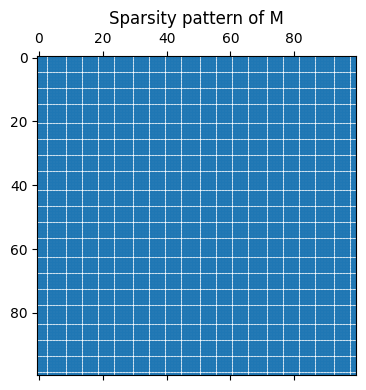

In [14]:
# plot sparsity pattern of M

plt.figure(figsize=(10, 4))
plt.title("Sparsity pattern of M")
plt.spy(M_dense, markersize=2)
plt.tight_layout()
plt.show()

In [15]:
#diagonal singular value matrix sigma
sigma = np.zeros((n, n), dtype=complex)
for i in range(n):
    sigma[i, i] = np.sqrt(spectrum[i])

In [16]:
# Create a KSP solver for L_pet.
ksp = PETSc.KSP().create()
ksp.setOperators(L_pet)
ksp.setType("preonly")
pc = ksp.getPC()
pc.setType("lu")
ksp.setFromOptions()

# Create PETSc vectors for solution and right-hand-side.
svdV = L_pet.getVecs()[0].duplicate()
rhs = A_pet.getVecs()[0].duplicate()

svdV_array = []

# Solve for the i-th vector v[i].
for i in range(len(svdU_array)):

    # Compute rhs = sigma[i] * (A * svdU_array[i])
    A_pet.mult(svdU_array[i], rhs)
    rhs.scale(sigma[i, i])  # sigma stored as diagonal matrix

    # Solve L * v = rhs
    ksp.solve(rhs, svdV)
    svdV_array.append(svdV.copy())

In [17]:
#check for orthogonality
max_val = 0
for i in range(len(svdV_array)):
    for j in range(i+1, len(svdV_array)):
        val = svdV_array[i].dot(svdV_array[j])
        print("Orthogonality: ", np.abs(val))
        max_val = max(max_val, np.abs(val.real))
print("Max orthogonality: ", max_val)

Orthogonality:  6.845730867621096e-17
Orthogonality:  3.948664312192207e-16
Orthogonality:  1.5829351718288365e-16
Orthogonality:  5.675798372961616e-16
Orthogonality:  5.2258544713801314e-17
Orthogonality:  1.1514227071796057e-16
Orthogonality:  2.426444462022559e-16
Orthogonality:  2.0403329633461587e-17
Orthogonality:  3.449931312848875e-16
Orthogonality:  1.0321604682062002e-16
Orthogonality:  5.833007687972014e-17
Orthogonality:  9.660241356845845e-17
Orthogonality:  1.1796119636642288e-16
Orthogonality:  1.468009741545373e-16
Orthogonality:  1.8062808193608504e-16
Orthogonality:  4.570996359198887e-16
Orthogonality:  9.530137096147584e-17
Orthogonality:  8.342935717275957e-17
Orthogonality:  2.2741140567883456e-17
Orthogonality:  1.6523241108679088e-16
Orthogonality:  7.24247051220317e-17
Orthogonality:  1.5178830414797062e-18
Orthogonality:  1.5959455978986625e-16
Orthogonality:  7.15573433840433e-18
Orthogonality:  1.222980050563649e-16
Orthogonality:  4.9873299934333204e-17
Or

## reconstruct M from its SVD and compare with the original matrix

In [18]:
# M = A^-1 * L
# SVD of M
# M = U * Sigma * V^H

M_reconstructed = np.zeros((n, n), dtype=complex)

reconstruction_error = []

for i in range(nconv):
    u_array = svdU_array[i].getArray()
    v_array = svdV_array[i].getArray()
    M_reconstructed += sigma[i, i] * np.outer(u_array, np.conjugate(v_array))

    error = np.linalg.norm(M_dense - M_reconstructed, ord='fro')
    reconstruction_error.append(error)

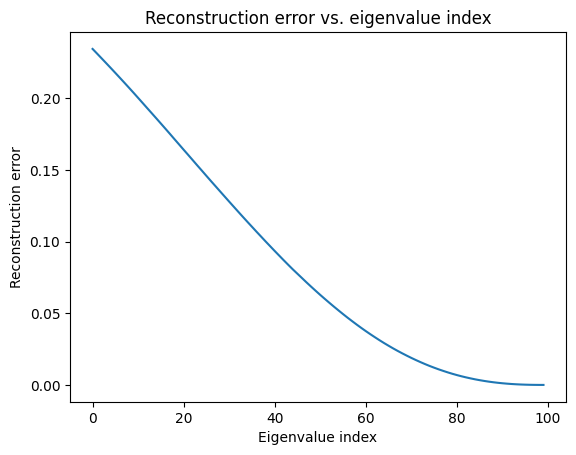

In [19]:
# Plot the reconstruction error.
plt.figure()
plt.plot(reconstruction_error)
plt.xlabel("Eigenvalue index")
plt.ylabel("Reconstruction error")
plt.title("Reconstruction error vs. eigenvalue index")
plt.show()

# export SVD

In [20]:
# import os
# os.makedirs(case_path + 'svd/', exist_ok=True)

In [21]:
# for iEv in range(nconv):
#     np.savez(case_path + 'svd/' + str(iEv), svdU=svdU_array[iEv].getArray(), svdV=svdV_array[iEv].getArray())

In [22]:
# for i in range(len(EWs)):
#     sv_data = np.load(case_path + 'svd/' + str(i) + '.npz')
#     svd_np = sv_data['svdU']

#     equation.q_real_list[equation.dof["u"]].vector().set_local(
#         np.real(svd_np[equation.VMixed.sub(equation.dof["u"]).dofmap().dofs()]))
#     equation.q_imag_list[equation.dof["u"]].vector().set_local(
#         np.imag(svd_np[equation.VMixed.sub(equation.dof["u"]).dofmap().dofs()]))

#     fields_to_write["svdU_real"] = equation.q_real_list[equation.dof["u"]]
#     fields_to_write["svdU_imag"] = equation.q_imag_list[equation.dof["u"]]

#     # Write eigenmodes and singular vectors.
#     io = Io()
#     io.write_paraview(geometry, settings, "eigen_singular_" + str(i), fields_to_write)

In [23]:
!jupyter nbconvert --to script svd_test.ipynb

[NbConvertApp] Converting notebook svd_test.ipynb to script
[NbConvertApp] Writing 8401 bytes to svd_test.py
